# **Stereo Matching Competition**

## 3D Data Processing - Project 2022-2023

## Group members : **Principe** Bruno, **Sambin** Luca

# Connect and mount your Google Drive

dataset link: https://drive.google.com/drive/folders/1pnawob_-gEc7pS2ycNwAAv3DdRlxh35B?usp=sharing

To add a link to the dataset in your Google Drive main folder, you need to:

 - Click on the link
 - Right click on "dataset"
 - Click Add shortcut to Drive

In [ ]:
!pip install albumentations

In [ ]:
!pip install tqdm

In [ ]:
conda install ipywidgets

In [ ]:
!pip install onnx 

#  Mount the Drive Folder :
**Set** the 'running_on_colab' = **True** for Load and Store information from and to Drive, otherwise set it to False and work locally

In [1]:
# Set this variable to True if you are using Colab
running_on_colab = False
# Mount Drive Folders
if running_on_colab:
    from google.colab import drive
    drive_path = '/content/drive'
    drive.mount(drive_path)

# Libraries

In [2]:
# Python Standard Libraries
import math 
import os
import glob
import pathlib
import random
from functools import reduce
from operator import __add__
# Image Processing Libraries
import numpy as np
import cv2
from albumentations import Resize, Compose
from albumentations.pytorch.transforms import  ToTensorV2
from albumentations.augmentations.transforms import Normalize
# Image Plotting
import matplotlib.pyplot as plt
# Deep Learning Library
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
# Processing Bar Library
from tqdm import tqdm, trange
# ONNX Library utilities
import onnx

# Preprocessing and Load the Dataset
Routines of the data are the followings :
 - Load the images from paths,
 - Create the pairs for each image alike = [estimated disparity, grayscaled left image, Ground truth],
 - Split it into Training, Validation
 - Load a Test set from another dataset

Define the the Class of the Dataset , Transformations that the data must undergo :
 - Training and Validation data :
    * left and disparity images converted to Tensors
    * Ground Truth Resized, Normalized and converted to Tensors
 - Test data :
    * Just convert Images to Tensors

Batch the 3 Datasets created for the belonged step

Define the Datasets Paths

In [3]:
if running_on_colab:
    # Colab Version
    # Training and Validation Dataset = Sintel
    data_path_train_l = os.path.join(drive_path,"MyDrive", "StereoVae", "Dataset", "train", "left")
    data_path_train_d = os.path.join(drive_path, "MyDrive", "StereoVae", "Dataset", "train", "disparity")
    data_path_train_gt = os.path.join(drive_path, "MyDrive", "StereoVae", "Dataset", "train", "groundtruth_disparity")
    
    # Test Dataset = In2022K
    #data_path_test_l = os.path.join(drive_path,"MyDrive", "StereoVae", "Dataset", "test", "left")
    #data_path_test_d = os.path.join(drive_path,"MyDrive", "StereoVae","Dataset", "test", "disparity")
    
    # Test Dataset = Kitti 2012 
    data_path_test_l = os.path.join(drive_path,"MyDrive", "StereoVae", "Dataset", "test_1" ,"left")
    data_path_test_d = os.path.join(drive_path,"MyDrive", "StereoVae", "Dataset","test_1" ,"disparity")

else:
    # Local Version
    path_ = pathlib.Path().resolve()
    # Training and Validation Dataset = Sintel
    data_path_train_l = os.path.join(path_,"Model", "Dataset", "train", "left")
    data_path_train_d = os.path.join(path_, "Model", "Dataset", "train", "disparity")
    data_path_train_gt = os.path.join(path_, "Model", "Dataset", "train", "groundtruth_disparity")

    # Test Dataset = In2022K
    #data_path_test_l = os.path.join(path_, "Model", "Dataset", "test", "left")
    #data_path_test_d = os.path.join(path_, "Model","Dataset", "test", "disparity")
    
    # Test Dataset = Kitti 2012 
    data_path_test_l = os.path.join(path_, "Model", "Dataset", "test_1" ,"left")
    data_path_test_d = os.path.join(path_, "Model","Dataset", "test_1" ,"disparity")

Create Train, Valid and Test sets and Collect the pairs path : [disparity, left, ground truth disparity]

In [4]:
def load_dataset(disp_path, left_path, gt_path=None, train=False):
    if train:
        # Store image paths in list
        t_img_path = [] 
        #1. Get all the paths from train_data_path and append image paths and class to to respective lists
        #  E.G. train path-> 'images/train/name_of_the_image.jpg'
        d_data = sorted(glob.glob(disp_path + '/*.jpg'), key=lambda x: int(os.path.splitext(os.path.basename(x))[0])) 
        l_data = sorted(glob.glob(left_path + '/*.jpg'), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        gt_data = sorted(glob.glob(gt_path + '/*.png'), key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        for i in range(len(d_data)):
            img_block = [d_data[i], l_data[i], gt_data[i]]
            t_img_path.append(img_block)
        print('train_image_path example: ', t_img_path[0])
        #2. split train valid from train paths (80,20)
        t_img_path, valid_image_paths = t_img_path[:int(0.8*len(t_img_path))], t_img_path[int(0.8*len(t_img_path)):] 
        print("Train size: {}\nValid size: {}\n".format(len(t_img_path), len(valid_image_paths)))
        return t_img_path, valid_image_paths
    else :
        #3.create the test_image_paths
        test_image_paths = []
        d_data = glob.glob(disp_path + '/*')
        l_data = glob.glob(left_path + '/*')
        for i in range(len(d_data)):
            img_block = [d_data[i], l_data[i]]
            test_image_paths.append(img_block)
        print('test_image_path example: ', test_image_paths[0])
        print("Test size: {}".format(len(test_image_paths)))
        return test_image_paths

In [5]:
train_l ,valid_l = load_dataset(data_path_train_d, data_path_train_l, data_path_train_gt, train=True) 
test_l = load_dataset(data_path_test_d, data_path_test_l, train=False)

train_image_path example:  ['/home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/Model/Dataset/train/disparity/01.jpg', '/home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/Model/Dataset/train/left/01.jpg', '/home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/Model/Dataset/train/groundtruth_disparity/0.png']
Train size: 851
Valid size: 213

test_image_path example:  ['/home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/Model/Dataset/test_1/disparity/111.jpg', '/home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/Model/Dataset/test_1/left/111.jpg']
Test size: 195


Preprocess Datasets and batch it.

In [6]:
class SyntethicStereoDataset():
    def __init__(self, image_paths, transform=False, gt_transform =False, test=False):
        self.image_paths = image_paths
        self.transform = transform
        self.gt_transform = gt_transform
        self.test = test
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        d_img = cv2.imread(image_filepath[0], cv2.IMREAD_GRAYSCALE)
        l_img = cv2.imread(image_filepath[1], cv2.IMREAD_GRAYSCALE)
        if self.test == False:
            gt_img = cv2.imread(image_filepath[2], cv2.IMREAD_GRAYSCALE)
            if self.gt_transform is not None:
                    gt_img = self.gt_transform(image=gt_img)["image"]
                    gt_img = gt_img.to(torch.float)
        if self.transform is not None:
            d_img = self.transform(image=d_img)["image"]
            d_img = d_img.to(torch.float)
            l_img = self.transform(image=l_img)["image"]
            l_img = l_img.to(torch.float)
        if self.test == False:
            return d_img, l_img, gt_img
        else :
            return d_img, l_img

In [7]:
# Define the transformation for the images
transforms = Compose([Normalize(mean=[0], std=[1]),
                      ToTensorV2()])
gt_transforms = Compose([Resize(396, 596, interpolation=cv2.INTER_NEAREST),
                        Normalize(mean=[0], std=[1]),
                        ToTensorV2()])
#  Create Dataset
train_ds = SyntethicStereoDataset(train_l, transforms, gt_transforms)
valid_ds = SyntethicStereoDataset(valid_l, transforms, gt_transforms)
test_ds = SyntethicStereoDataset(test_l, transforms, test = True) 

In [8]:
# Batching the Dataset : Training, Validation and Testing
train_loader  = DataLoader(dataset=train_ds,  batch_size=16, shuffle=True)
valid_loader  = DataLoader(dataset=valid_ds,  batch_size=16, shuffle=False)
test_loader   = DataLoader(dataset=test_ds,   batch_size=16,  shuffle=False)

# StereoVae :
Below are implemented the novel Variational Autoencoder in two versions : 
- The Architecture supported for the Conversion in ONNX format
- The version that works only in the Pytorch format

This is due to lack of support of the padding = 'same' during the conversion of the model from Pytorch to ONNX.

Here is the customize implementation of the CNN 2D Layer with Padding = 'same'.

The insight is to learn a model to correct and upscaling the reduced outcome of a customized Traditional Stereo Matching Algorithm with disparity size of 64 with a Variational AutoEncoder, the architecture is shown below.

![alt text](https://drive.google.com/uc?id=18KXRzCgVE40QZ6AXD1ARjaatXvXq5w10 "StereoVaeArch") 

The Network pipeline are just a train of Convolutional and Deconvolutional layers, and a final Upscaling layer followed by a Convolutional one.

The Loss is the sum of the Mean Absolute Loss (MAL) of the predicted disparity and the ground truth disparity with the KDNormal Loss :
 $$  -0.5 * {1 + \log(e^{(\sigma - 1)^2}) - (\mu-1)^2 - e^{(\sigma - 1)^2}}$$

Advantages :
* advantages of high processing speed of traditional methods
* and high accuracy of learning-based methods

Disadvantages : 
* there is still a gap in terms of accuracy compared with the current state-of-the-art methods, mainly because the proposed lightweight network lacks the required convolution kernels.

In [9]:
class Conv2dSamePadding(nn.Conv2d):
    def __init__(self,*args,**kwargs):
        super(Conv2dSamePadding, self).__init__(*args, **kwargs)
        self.zero_pad_2d = nn.ZeroPad2d(reduce(__add__,
            [(k // 2 + (k - 2 * (k // 2)) - 1, k // 2) for k in self.kernel_size[::-1]]))

    def forward(self, input):
        return  self._conv_forward(self.zero_pad_2d(input), self.weight, self.bias)

### StereoVae for Conversion to ONNX 

In [17]:
class StereoVAE(nn.Module):
    def __init__(self, imgChannels=1, featureDim=32*5*5, zDim=256, device="cuda"):
        super(StereoVAE, self).__init__()
        self.device = device
        # Mu and Sigma outputs of the Encoder
        self.mu = 0
        self.sigma = 0
        
        # Activation Function
        self.l_relu =  nn.LeakyReLU(negative_slope=0.1, inplace=True) 
        
        # Feature Block
        self.encConv1 = Conv2dSamePadding(imgChannels, 32, kernel_size=5, stride=1, padding=0, bias=True)
        
        # Encoder Block
        self.encConv2 = nn.Conv2d(64, 16, kernel_size=5, stride=2, bias=True)
        self.encConv3 = Conv2dSamePadding(16, 8, kernel_size=5, stride=1, padding=0, bias=True)
        self.encConv4 = nn.Conv2d(24, 32, kernel_size=5, stride=2, bias=True)
        self.encConv5 = Conv2dSamePadding(32, 16, kernel_size=5, stride=1, padding=0, bias=True)
        self.encConv6 = Conv2dSamePadding(48, 2, kernel_size=1, stride=1,padding=0, bias=True)

        # Vae Block
        self.decConv0 = Conv2dSamePadding(1, 32, kernel_size=1, stride=1, padding=0, bias=True)
        
        # Decoder Block
        self.decConv1 = Conv2dSamePadding(96, 16, kernel_size=5, stride=1, padding=0, bias=True)
        self.decConv2 = nn.ConvTranspose2d(112, 16, kernel_size=6, stride=2, bias=True)
        self.decConv3 = Conv2dSamePadding(40, 8, kernel_size=5, stride=1, padding=0, bias=True)
        self.decConv4 = nn.ConvTranspose2d(48, 16, kernel_size=6, stride=2, bias=True)
        
        # Upsample Block
        self.upSample = torch.nn.Upsample(scale_factor=2,mode='nearest')
        self.upConv1 = nn.Conv2d(81, 1, kernel_size=5, bias=True)
        
    def feature_extraction(self, x_1, x_2):
        f_1 = self.l_relu(self.encConv1(x_1))
        f_2 = self.l_relu(self.encConv1(x_1))
        return f_1, f_2
        

    def encoder(self, f_1, f_2):
       # Concatenate the features and obtains the Residual
        en_1 = torch.cat((f_1, f_2), 1)
        en_1 = self.l_relu(self.encConv2(en_1))
        en_1_r = self.l_relu(self.encConv3(en_1))
        # Derive the 2nd Encoding parameters and compute its Residual
        en_2 = torch.cat((en_1, en_1_r), dim=1)
        en_2 = self.l_relu(self.encConv4(en_2))
        en_2_r = self.l_relu(self.encConv5(en_2))
        # Derive the 2 Dimensional Tensor where the 1st dimension is Mu and the Second is Sigma
        en_2_concat = en_2 = torch.cat((en_2, en_2_r), 1)
        mu_sigma = self.l_relu(self.encConv6(en_2_concat))
        return mu_sigma, en_1, en_1_r, en_2, en_2_r, en_2_concat

    def reparameterize(self, mu, logVar):
        #Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decoder(self, mu_sigma, en_1, en_1_r, en_2, en_2_r, en_2_concat):
        # Mu is the 1st dimension
        # Sigma is the 2nd dimension of the Encoder output Tensor
        self.mu = torch.unsqueeze(mu_sigma[:,0,:,:], 1)
        self.sigma = torch.unsqueeze(mu_sigma[:,1,:,:], 1)
        d_1 = self.Vae()
        d_1_conc = torch.cat((d_1, en_2, en_2_r), 1)
        d_1_r = self.l_relu(self.decConv1(d_1_conc))
        d_2_conc = torch.cat((d_1_conc, d_1_r), 1)
        d_2 = self.l_relu(self.decConv2(d_2_conc))
        d_2_2_conc = torch.cat((d_2, en_1, en_1_r), 1)
        d_2_r = self.l_relu(self.decConv3(d_2_2_conc))
        d_2_r_conc = torch.cat((d_2_2_conc, d_2_r), 1)
        d = self.l_relu(self.decConv4(d_2_r_conc))
        return d
        
    def Vae(self):
        z = torch.randn(self.mu.size()).to(self.device)
        gaussian = torch.add(torch.sub(self.mu, 1, alpha=1), torch.mul(z, torch.exp(torch.sub(self.sigma, 1, alpha=1))), alpha=1)
        out_1 = torch.mul(self.sigma, gaussian)
        d_1 = torch.add(out_1, self.mu, alpha=1)
        d_1 = self.l_relu(self.decConv0(d_1))
        return d_1
    
    def upSampling(self, d, x_1, f_1, f_2):
        out = torch.cat((d, x_1, f_1, f_2), 1)
        out = self.upSample(out)
        out = self.upConv1(out)
        return out
        
    def forward(self, x_1, x_2):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and sigma are returned for loss computation
        # Extract the features from the Disparity map and Left Grayscale image
        f_1, f_2 = self.feature_extraction(x_1, x_2)
        mu_sigma, en_1, en_1_r, en_2, en_2_r, en_2_concat = self.encoder(f_1, f_2)
        d = self.decoder(mu_sigma, en_1, en_1_r, en_2, en_2_r, en_2_concat)
        out = self.upSampling(d, x_1, f_1, f_2)
        return out

# Training
- Definitions of the Training routines
- Model Instantiation,
- Definition of the model Parameters,
- Train the model 

In [18]:
# Early Stopping class
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.pre_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta) or validation_loss == self.min_validation_loss or validation_loss == self.pre_validation_loss:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [19]:
# Initialize the Critereon Mean Absolute Loss
critereon_1 = torch.nn.L1Loss(reduction='mean')
critereon_2 = torch.nn.KLDivLoss(reduction='mean')

In [20]:
def StereoLoss(gt, pred, mu, sigma, critereon_1, critereon_2):
    gt = gt.to("cuda")
    # Mean Absolute Loss from the Prediction and the Target Disparity
    loss_1 = critereon_1(pred, gt)
    # KDLoss 
    mu_sq = torch.pow(torch.sub(mu,1),2) 
    sigma_sq = torch.exp(torch.pow(torch.sub(sigma,1),2)) 
    loss_2 = -0.5 * torch.mean( 1 + torch.log(sigma_sq) - mu_sq - sigma_sq)
    # Stereo Loss = MALoss + KLNormalLoss
    loss = (loss_1 + loss_2)
    return loss

In [21]:
def train(model, dataloader, optimizer, epoch, critereon_1, critereon_2):
    train_loss = []
    total_loss = 0
    pbar = tqdm(dataloader, leave=False)
    model.train()
    for (disp_1_img, left_img, gt) in pbar:
        pbar.set_description(f"train - epoch {epoch} - ")
        optimizer.zero_grad()
        disp_1_img = disp_1_img.to("cuda")
        left_img = left_img.to("cuda")
        pred = model(disp_1_img, left_img)
        mu = model.mu 
        sigma = model.sigma
        loss = StereoLoss(gt, pred, mu, sigma, critereon_1, critereon_2)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    loss_f = np.asarray(train_loss).mean()
    return loss_f

In [22]:
def test(model, dataloader, epoch=None, critereon_1=None, critereon_2=None):
    model.eval()
    pred_l = []
    valid_loss = []
    conf_m_f = np.zeros((4,4))
    batches = dataloader
    if epoch != None:
        pbar = tqdm(dataloader, leave=False)
        batches = pbar
    for data in batches:
        disp_1_img = data[0]
        left_img = data[1]
        if epoch != None:
            pbar.set_description(f"valid - epoch {epoch} - ")
        with torch.no_grad():
            disp_1_img = disp_1_img.to("cuda")
            left_img = left_img.to("cuda")
            pred = model(disp_1_img, left_img)
            pred_l.append(pred)
            if epoch != None:
                gt = data[2]
                loss = StereoLoss(gt, pred, model.mu, model.sigma, critereon_1, critereon_2)
                valid_loss.append(loss.item())
    if epoch != None:
        loss_f = np.asarray(valid_loss).mean()
        return loss_f
    else :
        return pred_l

In [23]:
def training_loop(model, train_dataloader, valid_dataloader, epochs, optimizer, critereon_1, critereon_2):
        train_loss_l = []
        valid_loss_l = []
        # Initialize the Best loss to the worst case
        best_valid = 5000
        # Assert of NaN values (Debugging Mode Only), comment the line if is working
        torch.autograd.set_detect_anomaly(True)
        # Dynamic Learning Rate initialization
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')
        # Early stopping Initialization
        early_stopper = EarlyStopper(patience=10, min_delta=0)
        for epoch in range(epochs):
            train_loss = train(model, train_dataloader, optimizer, epoch, critereon_1, critereon_2)
            val_loss = test(model, valid_dataloader, epoch, critereon_1, critereon_2)
            train_loss_l.append(train_loss)
            valid_loss_l.append(val_loss)
            print("")
            print("Epoch: {:3d} - train_loss: {:5.3f} - valid_loss: {:5.3f} ".format(epoch, train_loss, val_loss))
            # update the best Mean Training Loss and Save the Best model so far
            if val_loss < best_valid:
                best_valid = val_loss
                path = ""
                if running_on_colab:
                    # Colab Version
                    path = os.path.join(drive_path, "MyDrive", "StereoVae", "stereo_vae_best.pt")
                else :
                    # Local Version
                    path = os.path.join(path_, "stereo_vae_best.pt")
                print("best_loss:", best_valid, "saving model at", path)
                torch.save(model.state_dict(), path)
            scheduler.step(val_loss)
            # Check if there is an improvement or not
            early = early_stopper.early_stop(val_loss)
            if early:
                print("Early Stopping")
                break
        return train_loss_l, valid_loss_l, best_valid

### Instantiation of the model, its parameters and device :

In [24]:
# Check the GUP Availability
device = "cpu"
if torch.cuda.is_available():
    print("CUDA Selected")
    device = torch.device("cuda")
# Initialize the model and parameters
epochs = 100 
lr = 0.0005 
stereovae = StereoVAE()
stereovae.to(device);

CUDA Selected


### Architecture in detail :

In [25]:
stereovae

StereoVAE(
  (l_relu): LeakyReLU(negative_slope=0.1, inplace=True)
  (encConv1): Conv2dSamePadding(
    1, 32, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(2, 2))
  (encConv3): Conv2dSamePadding(
    16, 8, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv4): Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2))
  (encConv5): Conv2dSamePadding(
    32, 16, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv6): Conv2dSamePadding(
    48, 2, kernel_size=(1, 1), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((0, 0, 0, 0))
  )
  (decConv0): Conv2dSamePadding(
    1, 32, kernel_size=(1, 1), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((0, 0, 0, 0))
  )
  (decConv1): Conv2dSamePadding(
    96, 16, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (decConv2): ConvTranspose2d(112, 16, kernel_size=(6

Total Number of Parameters and Trainable Parameters in StereoVae :

In [26]:
# Total Number of Parameters in StereoVae
pytorch_total_params = sum(p.numel() for p in stereovae.parameters())
# Total number of Trainable Parameters in StereoVae
pytorch_total_lr_params = sum(p.numel() for p in stereovae.parameters() if p.requires_grad)
print("Total Number of Parameters : "+ str(pytorch_total_params)+ "\nTotal Number of Trainable Parameters : "+str(pytorch_total_lr_params))

Total Number of Parameters : 202508
Total Number of Trainable Parameters : 202508


### Train the model :

In [27]:
optimizer = torch.optim.Adam(stereovae.parameters(), lr=lr)
train_loss_l, valid_loss_l, best_valid = training_loop(stereovae, train_loader, valid_loader, epochs, optimizer, critereon_1, critereon_2)


Epoch:   0 - train_loss: 0.379 - valid_loss: 0.301 
best_loss: 0.3005919786436217 saving model at /home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/stereo_vae_best.pt



Epoch:   1 - train_loss: 0.253 - valid_loss: 0.298 
best_loss: 0.29826625330107553 saving model at /home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/stereo_vae_best.pt



Epoch:   2 - train_loss: 0.246 - valid_loss: 0.294 
best_loss: 0.29408431372472216 saving model at /home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/stereo_vae_best.pt



Epoch:   3 - train_loss: 0.244 - valid_loss: 0.294 



Epoch:   4 - train_loss: 0.243 - valid_loss: 0.293 
best_loss: 0.29268195799418856 saving model at /home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/stereo_vae_best.pt



Epoch:   5 - train_loss: 0.242 - valid_loss: 0.312 



Epoch:   6 - train_loss: 0.241 - valid_loss: 0.296 



Epoch:   7 - train_loss: 0.240 - valid_loss: 0.302 



Epoch:   8 - train_loss: 0.240 - valid_loss: 0.295 



Epoch:   9 - train_loss: 0.239 - valid_loss: 0.295 



Epoch:  10 - train_loss: 0.237 - valid_loss: 0.293 
best_loss: 0.29260692106825964 saving model at /home/brprin/Scrivania/3D_Data_Processing/Nvidia_Competition/Nvidia-Git/StereoVae/stereo_vae_best.pt



Epoch:  11 - train_loss: 0.238 - valid_loss: 0.301 



Epoch:  12 - train_loss: 0.238 - valid_loss: 0.298 



Epoch:  13 - train_loss: 0.239 - valid_loss: 0.296 



Epoch:  14 - train_loss: 0.237 - valid_loss: 0.302 



Epoch:  15 - train_loss: 0.238 - valid_loss: 0.307 



Epoch:  16 - train_loss: 0.237 - valid_loss: 0.297 



Epoch:  17 - train_loss: 0.238 - valid_loss: 0.297 



Epoch:  18 - train_loss: 0.237 - valid_loss: 0.302 



Epoch:  19 - train_loss: 0.236 - valid_loss: 0.300 



Epoch:  20 - train_loss: 0.236 - valid_loss: 0.301 
Early Stopping


# Testing :
- Load the best model found so far,
- Test the model on the full Test Dataset,
- Print some example

In [28]:
# First we need to load the best model weights
if running_on_colab:
    # Colab Version
    path = os.path.join(drive_path, "MyDrive", "StereoVae", "stereo_vae_best.pt")
else :
    # Local Version
    path = os.path.join(path_, "stereo_vae_best.pt")

stereovae = StereoVAE()
stereovae.load_state_dict(torch.load(path))
stereovae.to(device)

StereoVAE(
  (l_relu): LeakyReLU(negative_slope=0.1, inplace=True)
  (encConv1): Conv2dSamePadding(
    1, 32, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv2): Conv2d(64, 16, kernel_size=(5, 5), stride=(2, 2))
  (encConv3): Conv2dSamePadding(
    16, 8, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv4): Conv2d(24, 32, kernel_size=(5, 5), stride=(2, 2))
  (encConv5): Conv2dSamePadding(
    32, 16, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (encConv6): Conv2dSamePadding(
    48, 2, kernel_size=(1, 1), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((0, 0, 0, 0))
  )
  (decConv0): Conv2dSamePadding(
    1, 32, kernel_size=(1, 1), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((0, 0, 0, 0))
  )
  (decConv1): Conv2dSamePadding(
    96, 16, kernel_size=(5, 5), stride=(1, 1)
    (zero_pad_2d): ZeroPad2d((2, 2, 2, 2))
  )
  (decConv2): ConvTranspose2d(112, 16, kernel_size=(6

### Test the best model :

In [29]:
pred_l = test(stereovae, test_loader)

# Image Statistics :
- Print a Training sample 
- Print 2 output Disparity from StereoVae

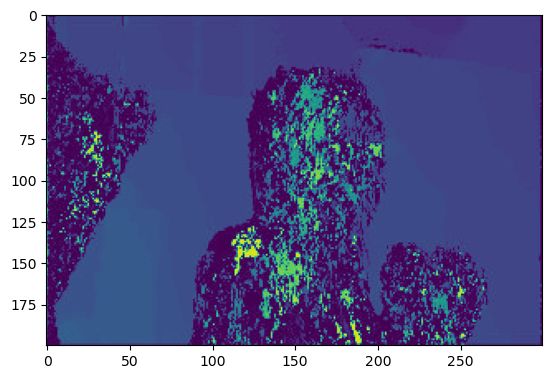

In [30]:
img = train_ds.__getitem__(0)[0]
img = img.permute(1, 2, 0)
plt.imshow(img)

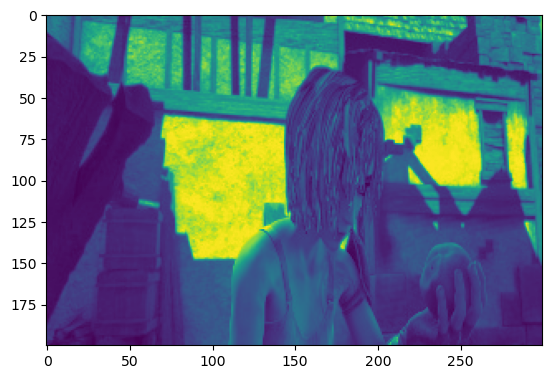

In [31]:
img = train_ds.__getitem__(0)[1]
img = img.permute(1, 2, 0)
plt.imshow(img)

3


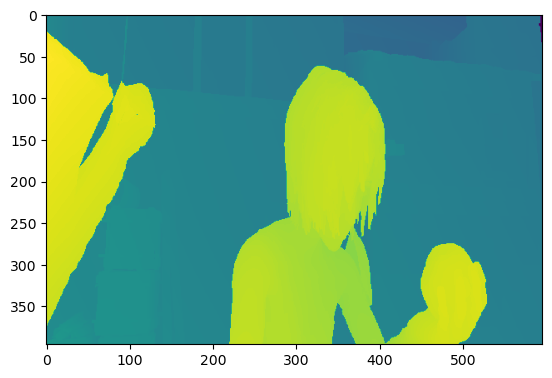

In [32]:
#train_loader
print(len(train_ds.__getitem__(0)))
img = train_ds.__getitem__(0)[2]
img = img.permute(1, 2, 0)
plt.imshow(img)

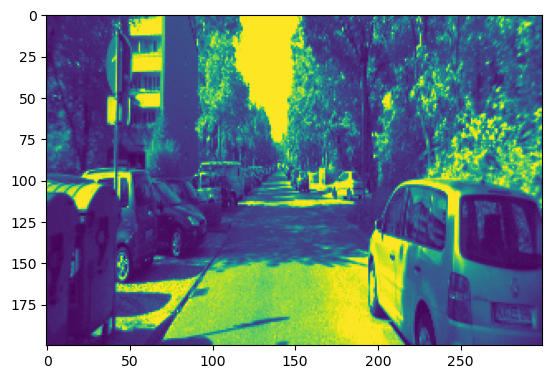

In [33]:
img = test_ds.__getitem__(10)[1]
img = img.permute(1, 2, 0)
plt.imshow(img)

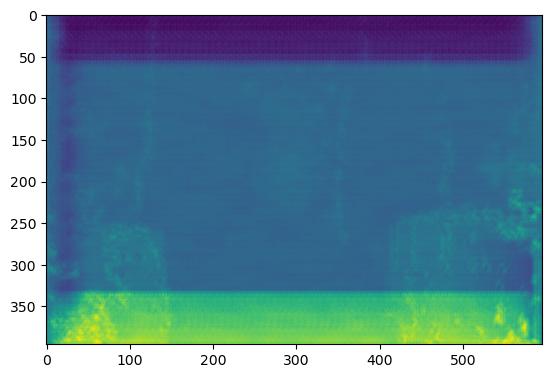

In [34]:
# Show the Disparity result
out_1 = pred_l[10][1,:,:,:].permute(1, 2, 0).to("cpu")
out = out_1.numpy()
plt.imshow(out_1)
disp = cv2.resize(out, (800, 300), interpolation=cv2.INTER_LINEAR) 
disp_vis = (disp - disp.min()) / (disp.max() - disp.min()) * 255.0
disp_vis = disp_vis.astype("uint8")
im_color = cv2.applyColorMap(disp_vis, cv2.COLORMAP_JET)

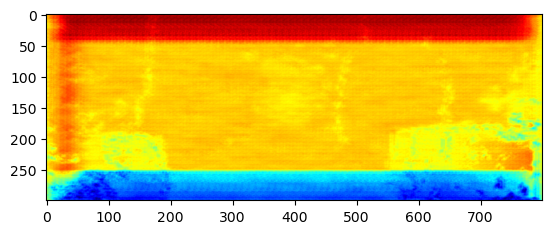

In [35]:
# Color Grid
plt.imshow(im_color)

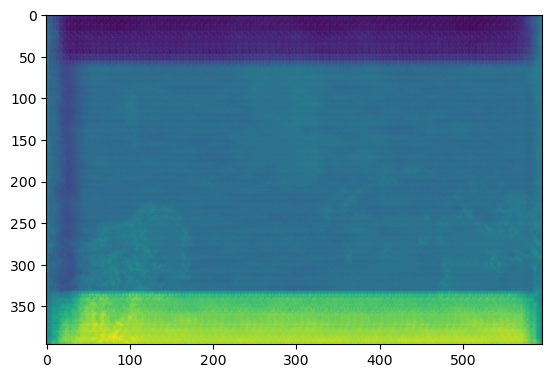

In [36]:
# Show the Disparity result
out_1 = pred_l[4][0,:,:,:].permute(1, 2, 0).to("cpu")
out = out_1.numpy()
plt.imshow(out_1)
disp = cv2.resize(out, (800, 300), interpolation=cv2.INTER_LINEAR) 
disp_vis = (disp - disp.min()) / (disp.max() - disp.min()) * 255.0
disp_vis = disp_vis.astype("uint8")
im_color = cv2.applyColorMap(disp_vis, cv2.COLORMAP_JET)

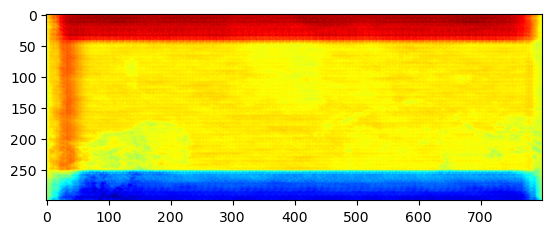

In [37]:
# Color Grid
plt.imshow(im_color)

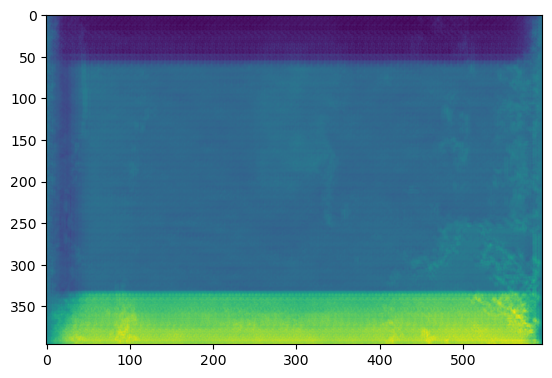

In [38]:
# Show the Disparity result
out_1 = pred_l[9][1,:,:,:].permute(1, 2, 0).to("cpu")
out = out_1.numpy()#out = np.array(out_1,np.uint)
plt.imshow(out_1)

disp = cv2.resize(out, (800, 300), interpolation=cv2.INTER_LINEAR) 
disp_vis = (disp - disp.min()) / (disp.max() - disp.min()) * 255.0
disp_vis = disp_vis.astype("uint8")
im_color = cv2.applyColorMap(disp_vis, cv2.COLORMAP_JET)

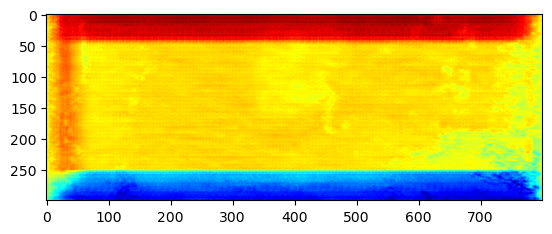

In [39]:
# Color Grid
plt.imshow(im_color)

# Conversion on ONNX format

The conversion of the Pytorch model into ONNX format is achiaved by :

* Create a dummy tensor of the same shape of the model input , in our case (Reduced Disparity Estimated and Reduced Left image)
* Perform the conversion
* Check if the conversion is succeded

The class preprocess_image(disp_path, l_path, trt = False) = takes as input tensors of the disparity estimation, the path of the reduced left images and the boolean trt (tensorrt) which if true return a concatenation of the 2 tensors otherwise just the 2 Batched Tensors.

In [40]:
def preprocess_image(disp, left, trt = False):
     disp = disp.unsqueeze(0).cuda()
     left = left.unsqueeze(0).cuda()
     if trt == True:
            disp_and_left = torch.cat((disp, left), 0)
            return disp_and_left
     else :
         return disp, left

In [41]:
disp = train_ds.__getitem__(4)[0]
left = train_ds.__getitem__(4)[1]
input_1, input_2 = preprocess_image(disp, left, False)
print(input_1.size())
print(input_2.size())
input_1 = input_1.cuda()
input_2 = input_2.cuda()

torch.Size([1, 1, 200, 300])
torch.Size([1, 1, 200, 300])


In [50]:
# Define the Path to save the .ONNX model
ONNX_FILE_PATH = 'stereovae_v17.onnx'
if running_on_colab:
    # Colab Version
    path = os.path.join(drive_path, "MyDrive", "StereoVae", ONNX_FILE_PATH)
else :
    # Local Version
    path = os.path.join(path_, ONNX_FILE_PATH)
# Convert the model from Pytorch to ONNX
torch.onnx.export(stereovae, (input_1,input_2), path, input_names=["input_1", "input_2"],output_names=['output'], export_params=True, opset_version=17) 

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [51]:
onnx_model = onnx.load(path)
onnx.checker.check_model(onnx_model)